In [1]:
%load_ext autoreload

%autoreload 2

In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import osmnx as ox
from typing import List, Tuple, Dict, Any, Optional
from networkx import Graph
from metroscore.network_builder import *
from shapely.geometry import Point, LineString
from random import random, choice
import pandas as pd
import partridge as ptg
import geopandas as gpd
import folium

%config InlineBackend.figure_format = 'retina'

In [8]:
PLACE = "Beacon, NY, USA"

# Importing Drive-Time networks

In this section, we will import a road network for a given place, clean it,
and ensure we have an attribute for all edges called "drive" which indicates the number
of seconds it will take to traverse that section of road.

In [9]:
G = ox.graph_from_place(
    PLACE, 
    retain_all=False, 
    truncate_by_edge=True, 
    simplify=True, 
    network_type='drive'
)
G = ox.project_graph(G)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [10]:
def get_random_edge(G: Graph) -> Tuple[int, int, Dict[str, Any]]:
    edge = choice(list(G.edges(data=True)))
    return edge

In [11]:
e = get_random_edge(G)
e

(261893312,
 261858161,
 {'osmid': 24182251,
  'name': 'Van Kleeck Avenue',
  'highway': 'residential',
  'oneway': False,
  'reversed': True,
  'length': 111.62,
  'geometry': <LINESTRING (587408.306 4594731.752, 587355.579 4594763.004, 587309.85 45947...>,
  'speed_kph': 59.3,
  'travel_time': 6.8})

In [12]:
def highlight_edge_in_graph(G: Graph, a: int, b: int):
    fig, ax = ox.plot_graph(G, show=False, close=False, edge_linewidth=0.5, node_size=0.8)
    ox.plot_graph_route(G, [a, b], route_linewidth=1.5, route_color='r', ax=ax)
    plt.show()

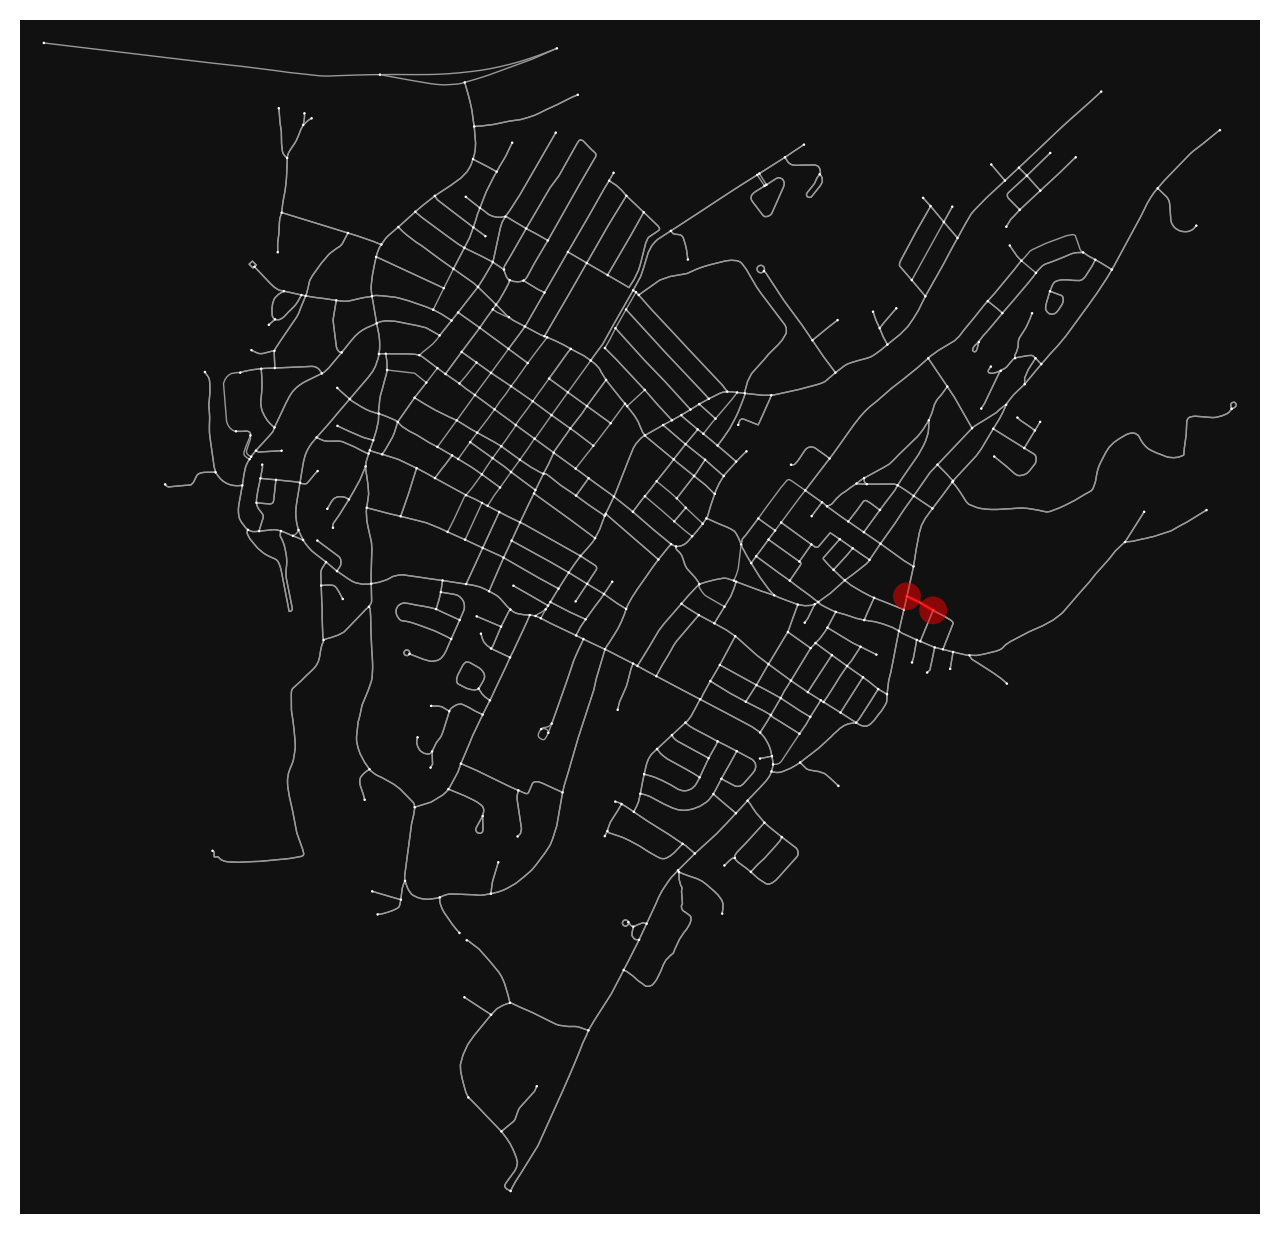

In [13]:
highlight_edge_in_graph(G, e[0], e[1])

In [14]:
# TODO: rename travel time to 'drive'

# Importing Bus Networks

This time, we'll create a network of bus routes. To do this, we'll start
with the road network, then append a GTFS source to truncate the roads down to those traversed by buses.
Finally, we'll append travel times to the edges with the key 'bus'.

In [15]:
inpath = '../data/google_transit_manhattan.zip'
service_ids = ptg.read_busiest_date(inpath)[1]
view = {'trips.txt': {'service_id': {service_ids}}}

feed = ptg.load_geo_feed(inpath, view)

feed.shapes.head()
#       shape_id                                           geometry
#  0  cal_gil_sf  LINESTRING (-121.5661454200744 37.003512297983...
#  1  cal_sf_gil  LINESTRING (-122.3944115638733 37.776439059278...
#  2   cal_sf_sj  LINESTRING (-122.3944115638733 37.776439059278...
#  3  cal_sf_tam  LINESTRING (-122.3944115638733 37.776439059278...
#  4   cal_sj_sf  LINESTRING (-121.9031703472137 37.330157067882...

minlon, minlat, maxlon, maxlat = feed.stops.total_bounds
#  -122.412076, 37.003485, -121.566088, 37.77639

/Users/arunavgupta/Documents/metroscore/.venv/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/arunavgupta/Documents/metroscore/.venv/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [16]:
feed.trips.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
0,M104,MV_B4-Saturday-BM,MV_B4-Saturday-BM-139500_M104_101,41 ST via BROADWAY/7 AV,1,35387660,M1040156
1,M103,OH_B4-Saturday-BM,OH_B4-Saturday-BM-143500_M101_1,CITY HALL via LEX AV,1,35388931,M1030019
2,M15,OH_B4-Saturday-BM,OH_B4-Saturday-BM-141800_M15_201,SOUTH FERRY via 2 AV,1,35388858,M150023
3,M66,MQ_B4-Weekday-SDon,MQ_B4-Weekday-SDon-030000_M66_501,LINCOLN CENTER WEST END AV CROSSTOWN,1,35386172,M660076
4,M66,MQ_B4-Weekday-SDon,MQ_B4-Weekday-SDon-032000_M66_501,EAST SIDE YORK AV CROSSTOWN,0,35386172,M660002


In [17]:
# join shapes with trips
# shapes = feed.shapes.set_index('shape_id')
list(filter(lambda x: not x.startswith("_"), feed.__dir__()))

['get',
 'set',
 'agency',
 'calendar',
 'calendar_dates',
 'fare_attributes',
 'fare_rules',
 'feed_info',
 'frequencies',
 'routes',
 'shapes',
 'stops',
 'stop_times',
 'transfers',
 'trips']

In [18]:
feed.calendar

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,MQ_B4-Weekday-SDon,1,1,1,1,1,0,0,2024-04-01,2024-06-28
1,MV_B4-Weekday-SDon,1,1,1,1,1,0,0,2024-04-01,2024-06-28
2,MV_B4-Saturday-BM,0,0,0,0,1,0,0,2024-04-05,2024-06-28
3,OF_B4-Weekday-SDon,1,1,1,1,1,0,0,2024-04-01,2024-06-28
4,OH_B4-Weekday-SDon,1,1,1,1,1,0,0,2024-04-01,2024-06-28
5,OH_B4-Saturday-BM,0,0,0,0,1,0,0,2024-04-05,2024-06-28


In [19]:
from shapely.geometry import LineString, Point
from shapely.ops import substring
from pyproj import CRS
import warnings
from functools import partial

def split_linestring_with_points(ls: LineString, p: List[Point]) -> List[LineString]:
    # get distance projections of points to linestring
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        projections = [ls.project(p) for p in p]
    # sort projections
    projections.sort()
    # split lineßstring
    lines = [substring(ls, projections[i], projections[i+1]) for i in range(len(projections) - 1)]
    return lines

def make_edges(df: pd.DataFrame, use_real_route_shapes: bool = True) -> pd.DataFrame:
    df = df.sort_values('stop_sequence')
    res = pd.DataFrame({
        'u': df['stop_id'].values[:-1],
        'v': df['stop_id'].values[1:],
        "key": 0,
        "geometry": [LineString([df['stop_geometry'].values[i], df['stop_geometry'].values[i+1]]) for i in range(len(df) - 1)],
        "length": [df['stop_geometry'].values[i].distance(df['stop_geometry'].values[i+1]) for i in range(len(df) - 1)],
        "travel_time": df['departure_time'].values[1:] - df['departure_time'].values[:-1],
    }, index=None)
    if use_real_route_shapes:
        ls = df['trip_geometry'].values[0] # needs error handling for multiple geometries
        edges = split_linestring_with_points(ls, df['stop_geometry'].tolist())
        res = res.assign(geometry=edges)
        res = res.assign(length=list(map(lambda x: x.length, edges)))
    return res

fast_make_edges = partial(make_edges, use_real_route_shapes=False)

In [20]:
from partridge.gtfs import Feed

In [21]:
combined

NameError: name 'combined' is not defined

In [22]:
def build_edge_and_node_gdf(feed: Feed) -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    combined = (
        feed.stop_times[['trip_id', 'stop_id', 'departure_time', 'stop_sequence']]
        .merge(
            feed.trips[['trip_id', 'shape_id']], 
            on='trip_id', 
            how='left'
        )
        .merge(
            (
                feed.shapes
                .rename(columns={"geometry": "trip_geometry"})
                .dropna(subset=['trip_geometry'])
            ), 
            on='shape_id', 
            how="left"
        )
        .merge(
            (
                feed.stops[['stop_id', 'geometry']]
                .rename(columns={"geometry": "stop_geometry"})
                .dropna(subset=['stop_geometry'])
            ), 
            on='stop_id', 
            how="left"
        )
    )
    # confirm each trip only has one associated shape
    print(combined.groupby('trip_id').apply(lambda x: x['shape_id'].nunique()).max() == 1)
    edges_gdf = combined.groupby('trip_id').apply(fast_make_edges).set_index(['u', 'v', 'key']).drop_duplicates()
    nodes_gdf = feed.stops[['stop_id', 'geometry']].set_index('stop_id')
    nodes_gdf['x'] = nodes_gdf['geometry'].x
    nodes_gdf['y'] = nodes_gdf['geometry'].y

    # attach crs
    crs = CRS.from_user_input(4326)
    nodes_gdf.crs = crs
    edges_gdf.crs = crs

    return nodes_gdf, edges_gdf

nodes_gdf, edges_gdf = build_edge_and_node_gdf(feed)

nodes_gdf.shape, edges_gdf.shape

True


((1837, 3), (14916, 3))

In [23]:
# build graph using osmnx
bus_network = ox.graph_from_gdfs(nodes_gdf, edges_gdf)

In [24]:
# ox.plot_graph(bus_network, figsize=(12, 12), node_size=0.8, edge_linewidth=0.5)
m = ox.graph_to_gdfs(bus_network, nodes=False, edges=True).explore(name="Routes")
m = ox.graph_to_gdfs(bus_network, nodes=True, edges=False).explore(m=m, color='red', radius=50, name="Stops")

folium.LayerControl().add_to(m)

m.save('bus_network.html')

m

In [25]:
e = get_random_edge(bus_network)
e

('401410',
 '401411',
 {'geometry': <LINESTRING (-73.992 40.764, -73.99 40.766)>,
  'length': 0.0026530955504857536,
  'travel_time': 65.0})

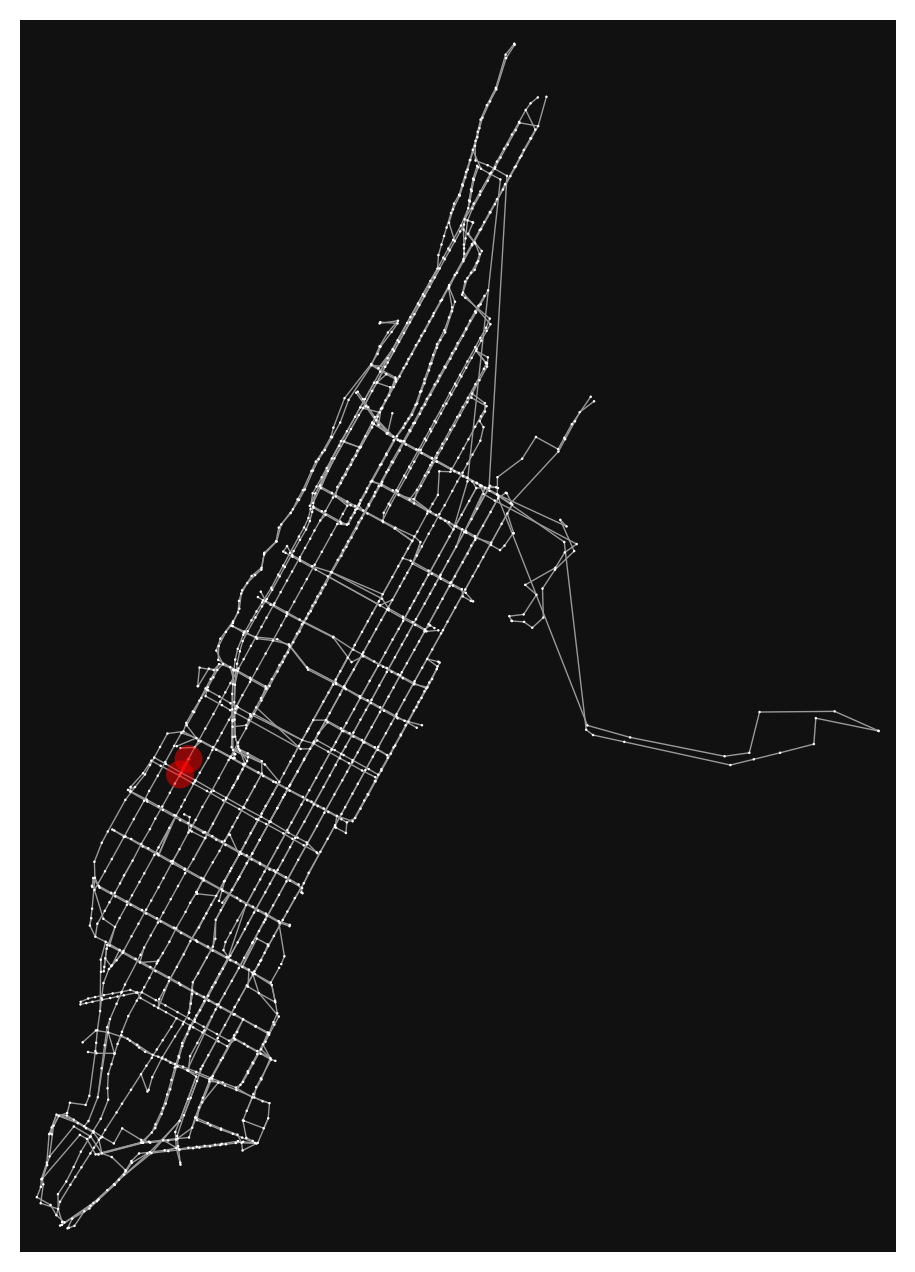

In [26]:
highlight_edge_in_graph(bus_network, e[0], e[1])

# Importing Rail Networks

Similar to bus networks, we'll import a rail network and use GTFS to append travel times for each edge.

~~Idea: use average wait time and add that to the edge's travel time in lieu of specific headways given departure time~~

In [27]:
inpath = '../data/google_transit.zip'
service_ids = ptg.read_busiest_date(inpath)[1]
view = {'trips.txt': {'service_id': service_ids}}

feed = ptg.load_geo_feed(inpath, view)

feed.routes.head()

,agency_id,route_id,route_short_name,route_long_name,route_type,route_desc,route_url,route_color,route_text_color
0,MTA NYCT,1,1,Broadway - 7 Avenue Local,1,Trains operate between 242 St in the Bronx and...,http://web.mta.info/nyct/service/pdf/t1cur.pdf,EE352E,NaN
1,MTA NYCT,2,2,7 Avenue Express,1,"Trains operate between Wakefield-241 St, Bronx...",http://web.mta.info/nyct/service/pdf/t2cur.pdf,EE352E,NaN
2,MTA NYCT,3,3,7 Avenue Express,1,"Trains operate between 148 St, 7 Av, Manhattan...",http://web.mta.info/nyct/service/pdf/t3cur.pdf,EE352E,NaN
3,MTA NYCT,4,4,Lexington Avenue Express,1,Trains operate daily between Woodlawn/Jerome A...,http://web.mta.info/nyct/service/pdf/t4cur.pdf,00933C,NaN
4,MTA NYCT,5,5,Lexington Avenue Express,1,"Weekdays daytime, most trains operate between ...",http://web.mta.info/nyct/service/pdf/t5cur.pdf,00933C,NaN


In [28]:
nodes_gdf, edges_gdf = build_edge_and_node_gdf(feed)

nodes_gdf.shape, edges_gdf.shape

/Users/arunavgupta/Documents/metroscore/.venv/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/arunavgupta/Documents/metroscore/.venv/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


True


((991, 3), (2856, 3))

In [29]:
rail_network = ox.graph_from_gdfs(nodes_gdf, edges_gdf)

In [30]:
# ox.plot_graph(bus_network, figsize=(12, 12), node_size=0.8, edge_linewidth=0.5)
m = ox.graph_to_gdfs(rail_network, nodes=False, edges=True).explore(name="Routes")
m = ox.graph_to_gdfs(rail_network, nodes=True, edges=False).explore(m=m, color='red', radius=50, name="Stops")

folium.LayerControl().add_to(m)

m.save('rail_network.html')

m

In [31]:
e = get_random_edge(rail_network)
e

('243S',
 '244S',
 {'geometry': <LINESTRING (-73.95 40.657, -73.95 40.651)>,
  'length': 0.005842525652488913,
  'travel_time': 690.0})

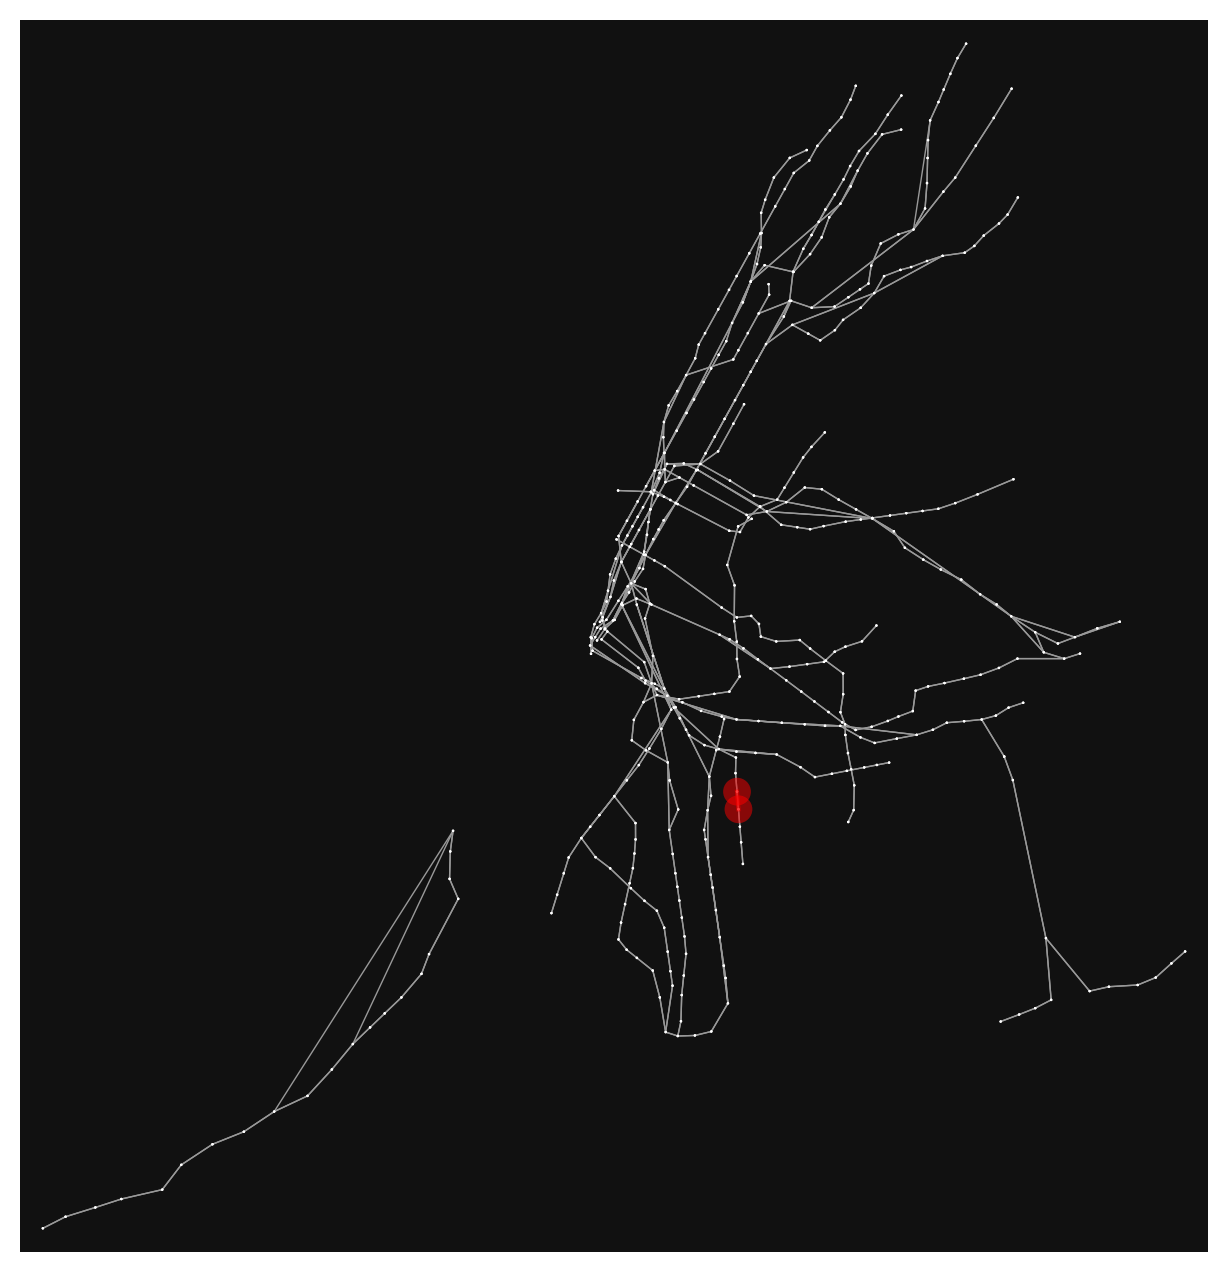

In [32]:
highlight_edge_in_graph(rail_network, e[0], e[1])

### Floyd-Warshall shortest paths

We'll need to modify the Floyd-Warshall algorithm to consider waiting time at each node given the path it's coming from/path it's going to.

In [ ]:
from metroscore.service_areas import floyd_warshall_fast

In [190]:
adj = nx.adjacency_matrix(rail_network, weight='travel_time').todense()
adj = np.where(adj == 0, np.inf, adj)
np.fill_diagonal(adj, 0.0)

sp = floyd_warshall_fast(adj)

In [195]:
sp[np.newaxis, 0, :].shape, sp[:, 0, np.newaxis].shape

((1, 991), (991, 1))

In [35]:
def make_timetable(stop_times: pd.DataFrame) -> pd.DataFrame:
    def _rollup(df):
        df = df.sort_values('stop_sequence')
        return pd.DataFrame({
            'from': df['stop_id'].values[:-1],
            'to': df['stop_id'].values[1:],
            "departure_time": df['departure_time'].values[:-1],
        }, index=None)
    return stop_times.groupby("trip_id").apply(_rollup).reset_index(drop=True)

In [40]:
make_timetable(feed.stop_times).groupby(['from', 'to']).apply(lambda x: sorted(x['departure_time'].values))

from  to  
101S  103S    [390.0, 1530.0, 2730.0, 3930.0, 5130.0, 6330.0...
103N  101N    [7830.0, 9030.0, 10230.0, 11430.0, 12630.0, 13...
103S  104S    [480.0, 1620.0, 2820.0, 4020.0, 5220.0, 6420.0...
104N  103N    [7530.0, 8730.0, 9930.0, 11130.0, 12330.0, 135...
104S  106S    [570.0, 1710.0, 2910.0, 4110.0, 5310.0, 6510.0...
                                    ...                        
S29S  S28S    [660.0, 2460.0, 4260.0, 6060.0, 7860.0, 9660.0...
S30N  S31N    [6000.0, 7800.0, 9600.0, 11400.0, 13200.0, 150...
S30S  S29S    [540.0, 2340.0, 4140.0, 5940.0, 7740.0, 9540.0...
S31S  S19S    [25260.0, 26160.0, 27060.0, 27960.0, 28860.0, ...
      S30S    [360.0, 2160.0, 3960.0, 5760.0, 7560.0, 9360.0...
Length: 1137, dtype: object

# Importing Bike Networks

This one's pretty simple. We just call OSMNx for it since it supports it out of the box.

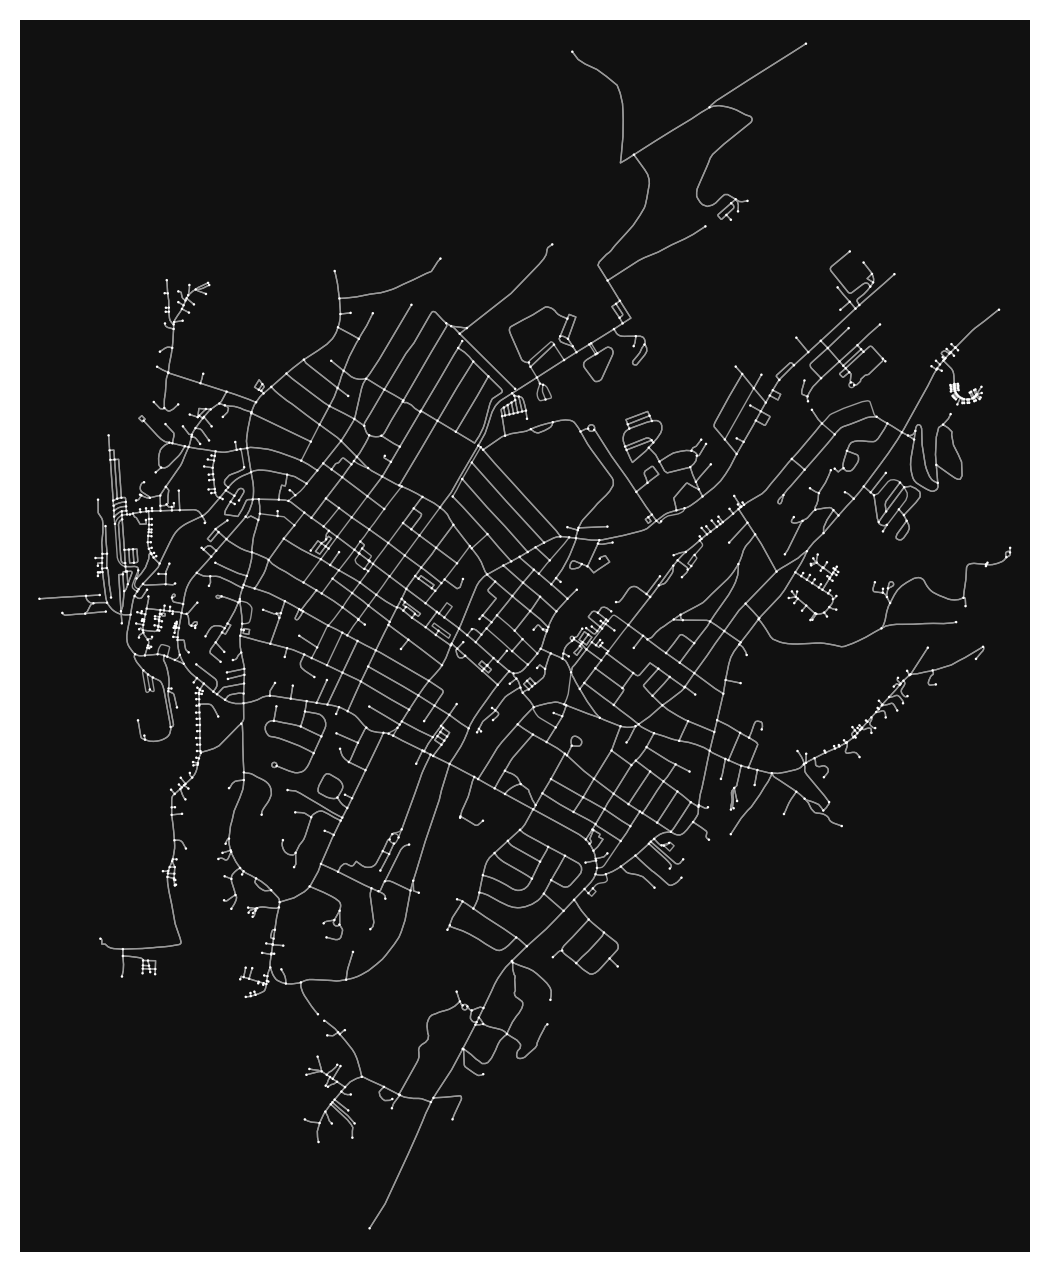

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
B = ox.graph_from_place(
    PLACE, 
    retain_all=False, 
    truncate_by_edge=True, 
    simplify=True, 
    network_type='bike'
)

ox.plot_graph(B, node_size=0.8, edge_linewidth=0.5)

In [4]:
len(B.nodes)

1549

In [71]:
ox.graph_to_gdfs(B, nodes=False, edges=True)

osmid            name      highway  oneway  \
u           v           key                                                    
261509145   261509152   0      24138532  Academy Street  residential   False   
261509152   261855051   0      24179603    South Avenue     tertiary   False   
            261509145   0      24138532  Academy Street  residential   False   
            261835049   0      24179603    South Avenue     tertiary   False   
261511488   7409319032  0      24138873             NaN      service   False   
...                                 ...             ...          ...     ...   
11821953551 11821959446 0    1273072632             NaN      service   False   
11821959445 11821959446 0    1273072646             NaN      service   False   
11821959446 11821953551 0    1273072632             NaN      service   False   
            11821959445 0    1273072646             NaN      service   False   
            8280460193  0    1273072632             NaN      service   False   

                            reversed   length  \
u           v           key                     
261509145   261509152   0      False  145.242   
261509152   261855051   0      False   40.093   
            261509145   0       True  145.242   
            261835049   0       True  102.986   
261511488   7409319032  0      False  378.782   
...                              ...      ...   
11821953551 11821959446 0       True   16.694   
11821959445 11821959446 0      False   14.068   
11821959446 11821953551 0      False   16.694   
            11821959445 0       True   14.068   
            8280460193  0       True  106.213   

                                                                      geometry  \
u           v           key                                                      
261509145   261509152   0    LINESTRING (-73.97948 41.50593, -73.97894 41.5...   
261509152   261855051   0    LINESTRING (-73.97788 41.50543, -73.97804 41.5...   
            261509145   0    LINESTRING (-73.97788 41.50543, -73.97794 41.5...   
            261835049   0    LINESTRING (-73.97788 41.50543, -73.97774 41.5...   
261511488   7409319032  0    LINESTRING (-73.95430 41.52331, -73.95440 41.5...   
...                                                                        ...   
11821953551 11821959446 0    LINESTRING (-73.96615 41.49946, -73.96605 41.4...   
11821959445 11821959446 0    LINESTRING (-73.96595 41.49950, -73.96605 41.4...   
11821959446 11821953551 0    LINESTRING (-73.96605 41.49960, -73.96615 41.4...   
            11821959445 0    LINESTRING (-73.96605 41.49960, -73.96595 41.4...   
            8280460193  0    LINESTRING (-73.96605 41.49960, -73.96586 41.4...   

                            service  ref access maxspeed lanes bridge tunnel  
u           v           key                                                   
261509145   261509152   0       NaN  NaN    NaN      NaN   NaN    NaN    NaN  
261509152   261855051   0       NaN  NaN    NaN      NaN   NaN    NaN    NaN  
            261509145   0       NaN  NaN    NaN      NaN   NaN    NaN    NaN  
            261835049   0       NaN  NaN    NaN      NaN   NaN    NaN    NaN  
261511488   7409319032  0       NaN  NaN    NaN      NaN   NaN    NaN    NaN  
...                             ...  ...    ...      ...   ...    ...    ...  
11821953551 11821959446 0       NaN  NaN    NaN      NaN   NaN    NaN    NaN  
11821959445 11821959446 0       NaN  NaN    NaN      NaN   NaN    NaN    NaN  
11821959446 11821953551 0       NaN  NaN    NaN      NaN   NaN    NaN    NaN  
            11821959445 0       NaN  NaN    NaN      NaN   NaN    NaN    NaN  
            8280460193  0       NaN  NaN    NaN      NaN   NaN    NaN    NaN  

[3694 rows x 14 columns]

In [67]:
from pyproj import CRS

CRS.from_user_input(4326)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich